In [1]:
import numpy as np
import tensorflow as tf #I deliberately installed an older version of tensorflow (1.14) will try 2.0 later
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_csv("./fer2013/fer2013/fer2013.csv") #downloaded from kaggle

In [3]:
df.Usage.value_counts() #train and test sets are already split

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Here we have an imbalanced dataset, and at the moment I couldn't find any explanation for the labels (downloaded them from kaggle but couldn't find a description). I'm gonna plot some images and try to guess what the labels mean. I should try to balance them using either undersampling or an oversampling technique (like SMOTE) or perhaps using data augmentation... but I am not going that far...

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

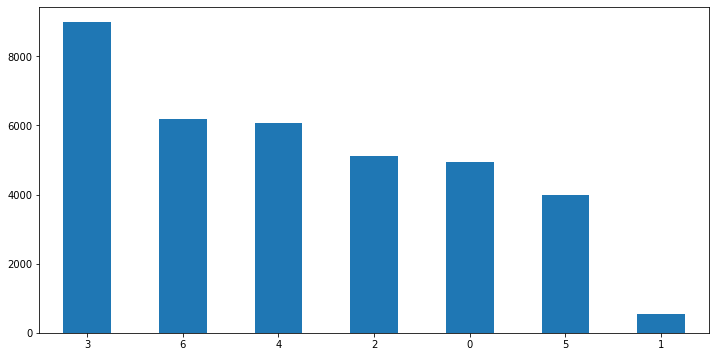

In [4]:
df.emotion.value_counts().plot.bar(figsize=(12,6))
plt.xticks(rotation=0)

In [5]:
#transforming the strings into numpy arrays
df.pixels = df.pixels.apply(lambda x: np.array(x.split()).astype(np.int16))

In [6]:
#getting the image side size in pixels (I know it's a square) -- it's 48 pixels
imageside = int(np.sqrt(df.pixels.loc[0].size))

Wow! I just figured I suck at recognizing facial expressions, I just can't tell really well which emotion is which. Maybe 0 is anger, 4 is sadness, 3 is happy, but 2 and 6? 1 Didn't even appear... probably due to our imabalance problem.  Anyways, it doesn't matter, I just want to test my deep learning skillzzzz ;)

EDIT: Just found out that 2 is fear, 6 is neutral and 1 is disgust -  and I also guessed the other labels correctly, guess I am not so bad after all

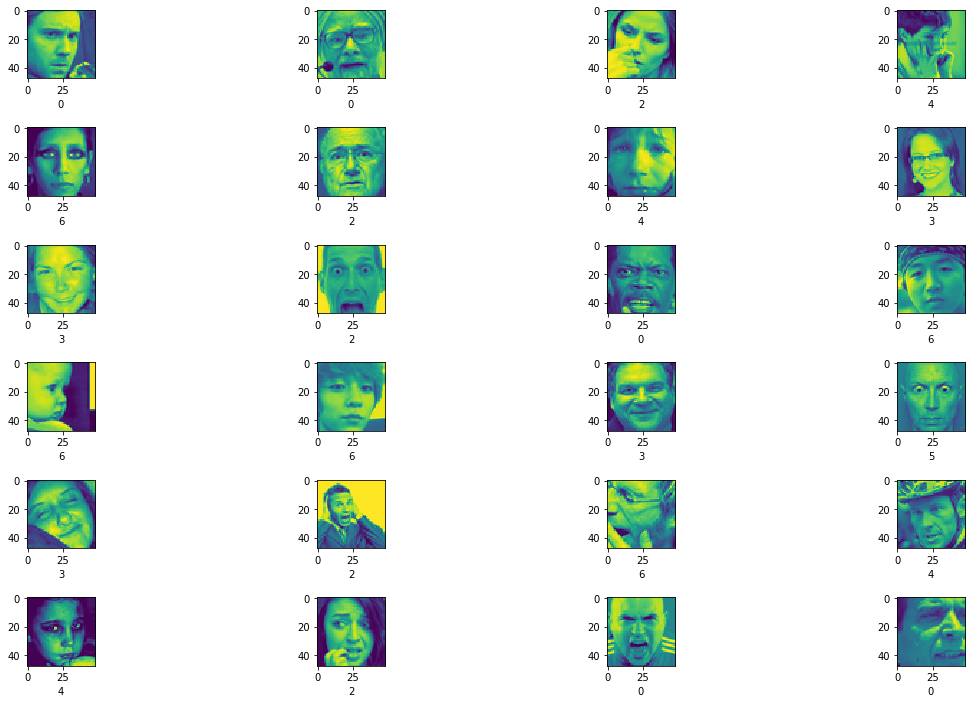

In [7]:
cols = 4
rows = 6
f, axarr = plt.subplots(rows,cols,figsize=(18,10))
for i in range(rows):
    for j in range(cols):
        axarr[i,j].imshow(df.pixels.loc[cols*i+j].reshape(imageside,imageside))
        axarr[i,j].set_xlabel(df.emotion.loc[cols*i+j])

f.tight_layout(pad=1.5)

In [66]:
X_train = np.array(df.query("Usage=='Training'").drop(["Usage","emotion"],axis=1)['pixels'].tolist())#/255.0 
#after I ran some tests, it seemed to work better without normalization - with ReLU activation 
#haven't run exhaustive tests though
y_train = df.query("Usage=='Training'").drop(["Usage","pixels"],axis=1)['emotion'].values
X_test = np.array(df.query("Usage=='PrivateTest'").drop(["Usage","emotion"],axis=1)['pixels'].tolist())#/255.0
#I am just using the privatetest as my test set...
y_test = df.query("Usage=='PrivateTest'").drop(["Usage","pixels"],axis=1)['emotion'].values

In [67]:
N = X_train.shape[0] #number of samples - 28709
D = X_train.shape[1] #number of inputs - 2304
M1 = int(X_train.shape[1]/2.0) #number of neurons in the first hidden layer 1152
M2 = int(X_train.shape[1]/2.0) #number of neurons in the second hidden layer 1152
K = np.unique(y_train).size #number of classes - 7

T = np.array([[0 if y_train[j] != i else 1 for i in range(K)] for j in range(N)]) #one-hot encoded target
T_test = np.array([[0 if y_test[j] != i else 1 for i in range(K)] for j in range(y_test.shape[0])]) #one-hot encoded target_test

I know I should be using the high-level API to make things simpler, but I just want to take my time and get some intuition on how the older tensorflow used to work...

In [68]:
#Initializing the weights for a 2 hidden layers neural network
W1 = init_weights([D,M1])
b1 = init_weights([M1])
W2 = init_weights([M1,M2])
b2 = init_weights([M2])
W3 = init_weights([M2,K])
b3 = init_weights([K])

In [69]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def feedforward(X, W1, W2, W3, b1, b2, b3):
    Z1 = tf.nn.relu(tf.matmul(X, W1) + b1)#relu activation
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)#relu activation
    return tf.matmul(Z2, W3) + b3#linear combination

tfX = tf.placeholder(tf.float32, [None,D])
tfY = tf.placeholder(tf.float32, [None,K])

py_x = feedforward(tfX, W1, W2, W3, b1, b2, b3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=tfY))

train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
predict_op = tf.argmax(py_x, 1)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accuracy_train = []
accuracy_test = []

for i in range(1000):
    sess.run(train_op, feed_dict={tfX:X_train, tfY:T})
    pred = sess.run(predict_op, feed_dict={tfX:X_train, tfY:T})
    pred_test = sess.run(predict_op, feed_dict={tfX:X_test, tfY:T_test})
    if i % 10 == 0:
        accuracy_train.append(np.mean(y_train==pred))
        accuracy_test.append(np.mean(y_test==pred_test))
        print("accuracy - train: {}".format(np.mean(y_train==pred)),
              "accuracy - test: {}".format(np.mean(y_test==pred_test)))        

accuracy - train: 0.2513149186666202 accuracy - test: 0.2449150181108944
accuracy - train: 0.2364763662962834 accuracy - test: 0.2385065477848983
accuracy - train: 0.2599533247413703 accuracy - test: 0.2596823627751463
accuracy - train: 0.26423769549618586 accuracy - test: 0.256896071329061
accuracy - train: 0.27984255808283115 accuracy - test: 0.2705488994148788
accuracy - train: 0.27900658330140377 accuracy - test: 0.2705488994148788
accuracy - train: 0.2783099376502142 accuracy - test: 0.2685984954026191
accuracy - train: 0.28774948622383223 accuracy - test: 0.2794650320423516
accuracy - train: 0.28771465394127277 accuracy - test: 0.2794650320423516
accuracy - train: 0.2917900310007315 accuracy - test: 0.2836444692114795
accuracy - train: 0.2980598418614372 accuracy - test: 0.2911674561159097
accuracy - train: 0.30171723153018215 accuracy - test: 0.29339648927277795
accuracy - train: 0.3047476401128566 accuracy - test: 0.2942323767066035
accuracy - train: 0.30819603608624474 accurac

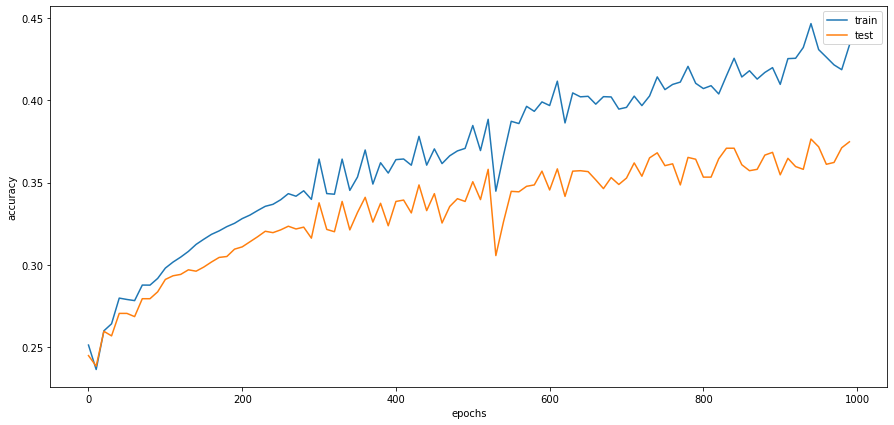

In [74]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.array(range(len(accuracy_train)))*10, accuracy_train)
plt.plot(np.array(range(len(accuracy_test)))*10, accuracy_test)
plt.legend(['train','test'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

It looks like I haven't reached convergence yet... Perhaps I should let it run for a couple thousand more epochs, but it just takes tooo long - don't wanna wait, and I think I proved my point here. Here's something else I found out about NNs, they take tooo long to train (it took like 2h using all the threads in my notebook). Seriously, I need to buy a nice workstation with a decent GPU card.

I also want to highlight tried some stuff here, but these hyperparameter settings seemed to work better. Here's the stuff I tried - most combinations:
   * Normalizing the inputs;
   * Sigmoid activation function in the hidden layers;
   * Increasing the learning rate, to increase training speed, but it seemed to have a negative impact on training;

Here's what I should also try:
   * Decreasing or increasing the number of hidden layers;
   * Toying with the number of hidden units in each layer;
   * Trying L1 and L2 regularization;
   * Trying different activations like tanh for instance;
   * Should probably learn how to use the higher level APIs to make things fast;
   * Buy a workstation with a GPU :(.